In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, grid_utils

In [2]:
from analyze_behav import process_behav
sublist = [1,2,3,4,5,6,7]
# sublist = [1]
# process_behav.preproc_main_task(sublist)
# process_behav.preproc_repeat_task(sublist)

In [3]:
all_grid_points = grid_utils.get_full_grid()
n_pts_all_grid = all_grid_points.shape[0]

In [4]:
grid_pts = grid_utils.get_main_grid()

In [5]:
subjects = np.arange(1,8)
# subjects = [1]
n_subj = len(subjects)

task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)
acc_by_task = np.zeros((n_subj, n_tasks));
acc_by_task_easy = np.zeros((n_subj, n_tasks));
acc_by_task_hard = np.zeros((n_subj, n_tasks));

rt_by_task = np.zeros((n_subj, n_tasks));
rt_by_task_easy = np.zeros((n_subj, n_tasks));
rt_by_task_hard = np.zeros((n_subj, n_tasks));

n_runs_total = 3 * 12
acc_by_run = np.full(fill_value=np.nan, shape=(n_subj, n_runs_total));

n_runs_each_task = int(n_runs_total / n_tasks)
diff_by_task = np.full(fill_value=np.nan, shape=(n_subj, n_tasks, n_runs_each_task));

# count how many trials they respond with each category label
resp_values = ['1','2','none']
n_resp_each_point = np.zeros((n_subj, n_tasks, n_pts_all_grid, len(resp_values)))

for si, ss in enumerate(subjects):
    
    bdat = pd.read_csv(os.path.join(root, 'DataBehavior','S%02d'%ss, 'S%02d_maintask_preproc_all.csv'%ss), \
                       index_col = 0)
    print(ss, bdat.shape[0]/48)
    
    resp = np.array(bdat['resp'])
    correct_resp = np.array(bdat['correct_resp'])
    rt = np.array(bdat['rt'])
    
    for ti in range(n_tasks):
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False)
        acc_by_task[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        rt_by_task[si,ti] = np.mean(rt[inds])
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False) & (bdat['is_main_grid']==1)
        acc_by_task_easy[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        rt_by_task_easy[si,ti] = np.mean(rt[inds])
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False) & (bdat['is_main_grid']==0)
        acc_by_task_hard[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        rt_by_task_hard[si,ti] = np.mean(rt[inds])
        
        runs_this_task = np.unique(bdat['run_overall'][bdat['task']==(ti+1)])
        # print(ti, runs_this_task)
        for ri, rr in enumerate(runs_this_task):
            
            diff = np.array(bdat['run_difficulty'][bdat['run_overall']==rr])[0]
            
            diff_by_task[si,ti,ri] = diff
        
    runs_overall = np.unique(bdat['run_overall'])
    # print(runs_overall)
    for ri,rr in enumerate(runs_overall):
        
        inds = (bdat['run_overall']==rr) & (bdat['timeout']==False)
        a = np.mean(resp[inds]==correct_resp[inds])
        # if a<0.50:
        #     print(ss, rr, np.sum(inds), a)
        #     print(resp[inds], correct_resp[inds])
        acc_by_run[si,ri] = a

    # loop over all trials
    for tr in range(bdat.shape[0]):
        dat = bdat.iloc[tr]
        
        task_ind = dat['task'] - 1
        grid_point_ind = np.where((all_grid_points[:,0]==dat['ptx']) & (all_grid_points[:,1]==dat['pty']))[0]
        assert(len(grid_point_ind)==1)
        if not np.isnan(dat['resp_unmapped']):
            resp_ind = int(dat['resp_unmapped']) - 1
        else:
            resp_ind = 2;
            
        n_resp_each_point[si,task_ind,grid_point_ind[0], resp_ind] +=1

1 36.0
2 36.0
3 36.0
4 36.0
5 36.0
6 33.0
7 36.0


/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


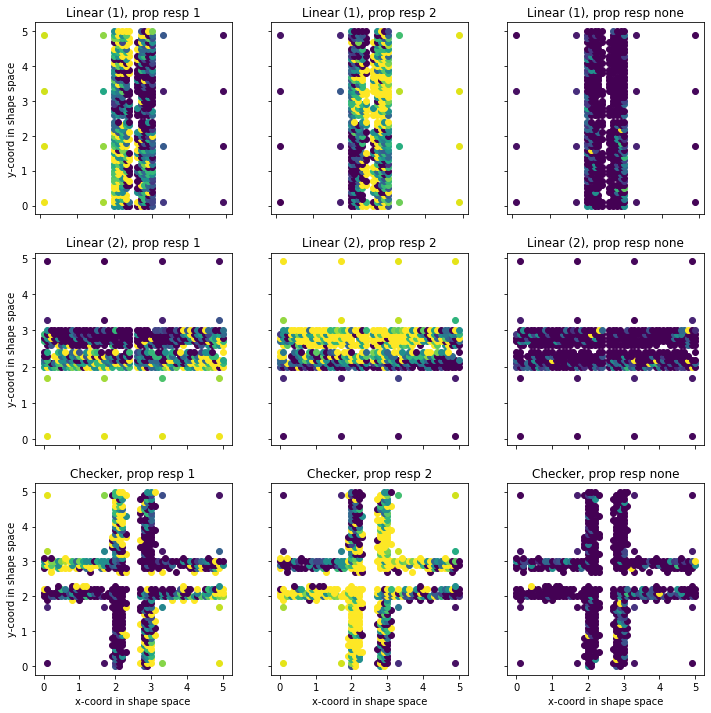

In [8]:
from matplotlib import cm

plt.figure(figsize=(12,12))
pi=0

# first summing over subjects
n_resp_summed = np.sum(n_resp_each_point, axis=0)

# now converting to a proportion of all trials
denom = np.tile( np.sum(n_resp_summed, axis=2, keepdims=True), [1,1,3])
prop_resp = n_resp_summed / denom
prop_resp[denom==0] = np.nan

# make a colormap
color_inds = np.linspace(0,1,100)
colors = cm.viridis(color_inds)

n_tasks = len(task_names)
for ti in range(n_tasks):
    
    for ri, resp_str in enumerate(resp_values):
        
        pr = prop_resp[ti,:,ri]
    
        pi+=1
        
        plt.subplot(3,3,pi)
        
        for pt in range(n_pts_all_grid):
            
            # plot the point if it was ever tested, skip if not
            if ~np.isnan(pr[pt]):
                
                # figure out what color to use, based on proportion value
                cind = np.argmin(np.abs(pr[pt]-color_inds))
                plt.plot(all_grid_points[pt,0], all_grid_points[pt,1], 'o', color=colors[cind])
    
        plt.title('%s, prop resp %s'%(task_names[ti], resp_str))
        
        if ti==2:
            plt.xlabel('x-coord in shape space')
            plt.xticks(np.arange(0,5.1,1))
        else:
            plt.xticks(np.arange(0,5.1,1),[])
        
        if ri==0:
            plt.ylabel('y-coord in shape space')
            plt.yticks(np.arange(0,5.1,1))
        else:
            plt.yticks(np.arange(0,5.1,1),[])
        
        

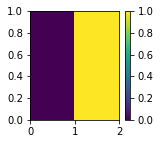

In [22]:
color_inds = np.linspace(0,1,100)
colors = cm.viridis(color_inds)
plt.figure(figsize=(2,2))
plt.pcolormesh(np.array([[0,1]]), cmap='viridis')
plt.colorbar()

In [10]:
# load data for repeat-detection (one-back) task
acc_repeat_task = np.full(fill_value=np.nan, shape=(n_subj,1));
acc_repeat_task_easy = np.full(fill_value=np.nan, shape=(n_subj,1));
acc_repeat_task_hard = np.full(fill_value=np.nan, shape=(n_subj,1));

rt_repeat_task = np.full(fill_value=np.nan, shape=(n_subj,1));
rt_repeat_task_easy = np.full(fill_value=np.nan, shape=(n_subj,1));
rt_repeat_task_hard = np.full(fill_value=np.nan, shape=(n_subj,1));

n_runs_repeat = 3 * 4

diff_repeat_task = np.full(fill_value=np.nan, shape=(n_subj, n_runs_repeat));
acc_repeat_by_run = np.full(fill_value=np.nan, shape=(n_subj, n_runs_repeat));


for si, ss in enumerate(subjects):
    
    bdat = pd.read_csv(os.path.join(root, 'DataBehavior','S%02d'%ss, 'S%02d_reptask_preproc_all.csv'%ss), \
                       index_col = 0)
    
    resp = np.array(bdat['resp'])
    correct_resp = np.array(bdat['correct_resp'])
    rt = np.array(bdat['rt'])
    
    inds = (bdat['timeout']==False)
    acc_repeat_task[si] = np.mean(correct_resp[inds]==resp[inds])
    rt_repeat_task[si] = np.mean(rt[inds])
    
    inds = (bdat['timeout']==False) & (bdat['is_main_grid']==1)
    acc_repeat_task_easy[si] = np.mean(correct_resp[inds]==resp[inds])
    rt_repeat_task_easy[si] = np.mean(rt[inds])
    
    inds = (bdat['timeout']==False) & (bdat['is_main_grid']==0)
    acc_repeat_task_hard[si] = np.mean(correct_resp[inds]==resp[inds])
    rt_repeat_task_hard[si] = np.mean(rt[inds])
    
    runs_this_task = np.unique(np.array(bdat['run_overall']))
    print(si, ss, runs_this_task)
    for ri, rr in enumerate(runs_this_task):

        diff = np.array(bdat['run_difficulty'][bdat['run_overall']==rr])[0]

        diff_repeat_task[si,ri] = diff
   
        inds = (bdat['run_overall']==rr) & (bdat['timeout']==False)
        a = np.mean(resp[inds]==correct_resp[inds])
        # if a<0.50:
        #     print(ss, rr, np.sum(inds), a)
        #     print(resp[inds], correct_resp[inds])
        acc_repeat_by_run[si,ri] = a


0 1 [ 1  2  3  4  5  6  7  8  9 10 11 12]
1 2 [ 1  2  3  4  5  6  7  8  9 10 11 12]
2 3 [ 1  2  3  4  5  6  7  8  9 10 11 12]
3 4 [ 1  2  3  4  5  6  7  8  9 10 11 12]
4 5 [ 1  2  3  4  5  6  7  8  9 10 11 12]
5 6 [ 1  2  3  4  5  6  7  8  9 10 11]
6 7 [1 2 3 4 5 6 7]


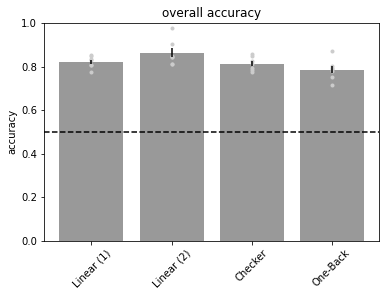

In [11]:
plt.figure(figsize=(6,4))

vals = np.concatenate([acc_by_task, acc_repeat_task], axis=1) 
n_tasks = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names + ['One-Back'], rotation=45)
plt.ylabel('accuracy')
plt.ylim([0, 1.0])
plt.axhline(0.5, color='k', linestyle='--')
plt.title('overall accuracy');

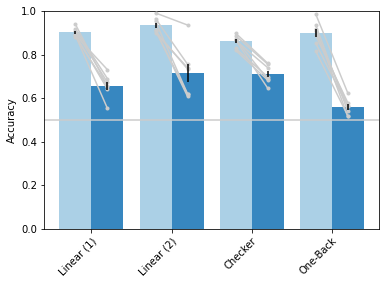

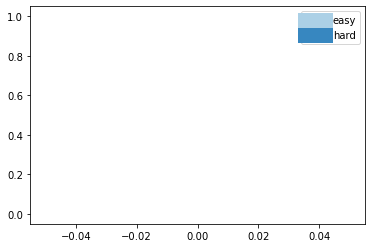

In [12]:
from code_utils import plot_utils
from matplotlib import cm

vals1 = np.concatenate([acc_by_task_easy[:,:,None], acc_by_task_hard[:,:,None]], axis=2)
vals2 = np.concatenate([acc_repeat_task_easy[:,:,None], acc_repeat_task_hard[:,:,None]], axis=2)
vals =np.concatenate([vals1, vals2], axis=1)
n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, point_data=vals, \
                           fig_size=(6,4), space = 0.1, \
                           add_ss_lines=True,
                          colors = cm.Blues(np.linspace(0,1,4))[1:3,:], \
                          legend_labels = ['easy','hard'], \
                          ylim = [0, 1], \
                          horizontal_line_pos = 0.5, \
                          xticklabels = task_names + ['One-Back'], \
                          ylabel='Accuracy');


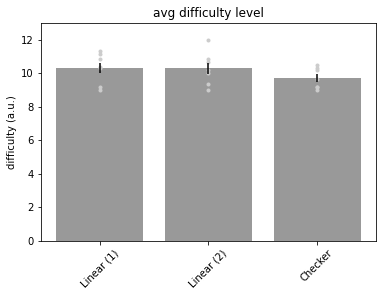

In [13]:
meandiff = np.nanmean(diff_by_task, axis=2)
vals = meandiff
n_tasks = meandiff.shape[1]

plt.figure(figsize=(6,4))

meanvals = np.nanmean(vals, axis=0)
semvals = np.nanstd(vals, axis=0)/np.sqrt(np.sum(~np.isnan(vals), axis=0))

plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('difficulty (a.u.)')
plt.ylim([0,13])
# plt.axhline(0.5, color='k', linestyle='--')
plt.title('avg difficulty level');

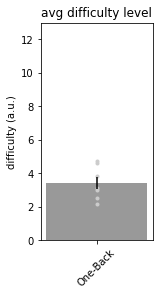

In [14]:
meandiff = np.nanmean(diff_repeat_task, axis=1, keepdims=True)
vals = meandiff
n_tasks = meandiff.shape[1]

plt.figure(figsize=(2,4))

meanvals = np.nanmean(vals, axis=0)
semvals = np.nanstd(vals, axis=0)/np.sqrt(np.sum(~np.isnan(vals), axis=0))

plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), ['One-Back'], rotation=45)
plt.ylabel('difficulty (a.u.)')
plt.ylim([0,13])
# plt.axhline(0.5, color='k', linestyle='--')
plt.title('avg difficulty level');

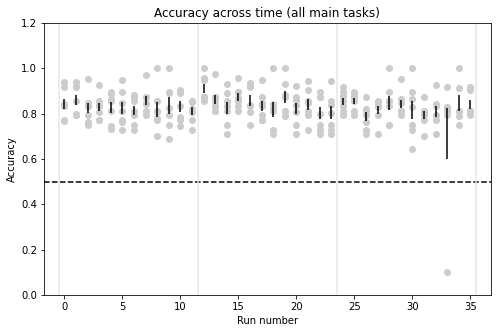

In [15]:
plt.figure(figsize=(8,5))
for ri in range(n_runs_total):
    vals = acc_by_run[:,ri]
    vals = vals[~np.isnan(vals)]
    plt.plot(ri*np.ones(np.shape(vals)), vals, 'o', color=[0.8, 0.8, 0.8])
    m = np.mean(vals)
    s = np.std(vals)/np.sqrt(len(vals))
    plt.errorbar(ri, m, s, color='k', zorder=10)
    
plt.ylabel('Accuracy')
plt.axhline(0.5, color='k', linestyle='--')
plt.title('Accuracy across time (all main tasks)');
plt.xlabel('Run number');
plt.ylim([0.0, 1.2]);

for se in np.arange(0, 37, 12):
    plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);

(-1.0, 12.0)

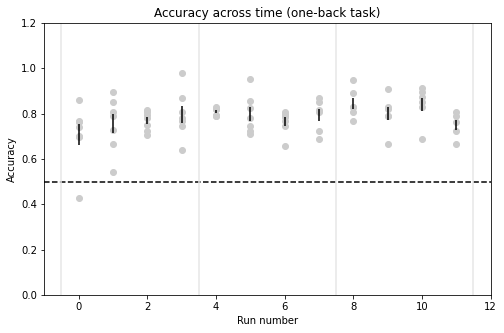

In [16]:
plt.figure(figsize=(8,5))
for ri in range(n_runs_repeat):
    vals = acc_repeat_by_run[:,ri]
    vals = vals[~np.isnan(vals)]
    plt.plot(ri*np.ones(np.shape(vals)), vals, 'o', color=[0.8, 0.8, 0.8])
    m = np.mean(vals)
    s = np.std(vals)/np.sqrt(len(vals))
    plt.errorbar(ri, m, s, color='k', zorder=10)
    
plt.ylabel('Accuracy')
plt.axhline(0.5, color='k', linestyle='--')
plt.title('Accuracy across time (one-back task)');
plt.xlabel('Run number');
plt.ylim([0.0, 1.2]);

for se in np.arange(0, 13, 4):
    plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);
plt.xlim([-1, n_runs_repeat])

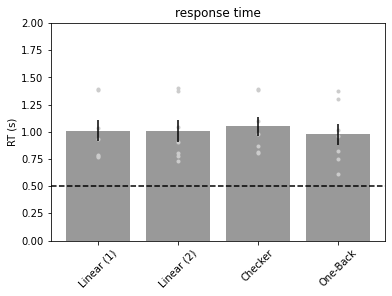

In [17]:
plt.figure(figsize=(6,4))

vals = np.concatenate([rt_by_task, rt_repeat_task], axis=1) 
n_tasks = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names + ['One-Back'], rotation=45)
plt.ylabel('RT (s)')
plt.ylim([0, 2.0])
plt.axhline(0.5, color='k', linestyle='--')
plt.title('response time');

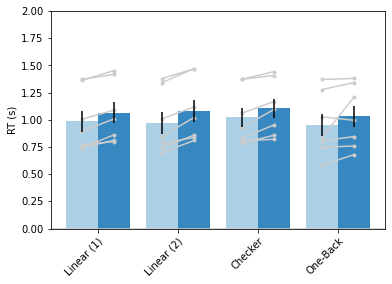

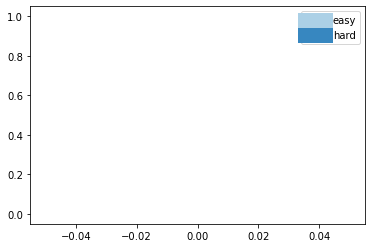

In [18]:
from code_utils import plot_utils
from matplotlib import cm

vals1 = np.concatenate([rt_by_task_easy[:,:,None], rt_by_task_hard[:,:,None]], axis=2)
vals2 = np.concatenate([rt_repeat_task_easy[:,:,None], rt_repeat_task_hard[:,:,None]], axis=2)
vals =np.concatenate([vals1, vals2], axis=1)
n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, point_data=vals, \
                           fig_size=(6,4), space = 0.1, \
                           add_ss_lines=True,
                          colors = cm.Blues(np.linspace(0,1,4))[1:3,:], \
                          legend_labels = ['easy','hard'], \
                          ylim = [0, 2], \
                          horizontal_line_pos = 0, \
                          xticklabels = task_names + ['One-Back'], \
                          ylabel='RT (s)');


In [19]:
from code_utils import data_utils

lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    lab[ss] = main_labels
   

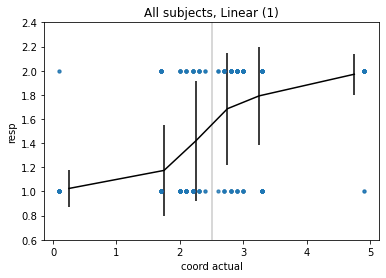

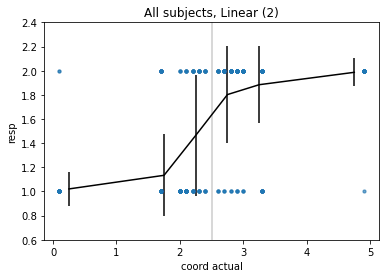

In [20]:
for ti, tt in enumerate([1,2]):

    x = []
    y = []

    for si, ss in enumerate(sublist):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = np.array(l['is_main_grid']==1)

        coord_actual = pt_labs[:,ti]

        resp = np.array(l['resp_unmapped']).astype(int)
        resp[~np.isin(resp, [1,2])] = 0

        x.append(coord_actual)
        y.append(resp)

    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)

    n_bins = 10;

    x_bin_edges = np.linspace(0, 5.0001, n_bins+1)
    x_binned = np.zeros((n_bins,))
    y_binned = np.zeros((n_bins,2))

    for bi in range(n_bins):
        inds = (x>=x_bin_edges[bi]) & (x<x_bin_edges[bi+1]) & (y>0)
        if np.sum(inds)>0:
            assert(not np.any(np.isnan(y[inds])))
            x_binned[bi] = np.mean(x_bin_edges[bi:bi+2])
            y_binned[bi,0] = np.mean(y[inds])
            y_binned[bi,1] = np.std(y[inds])
        else:
            x_binned[bi] = np.nan
    keep_inds = ~np.isnan(x_binned)
    x_binned = x_binned[keep_inds]
    y_binned = y_binned[keep_inds,:]

    plt.figure()

    inds = y>0
    plt.plot(x[inds], y[inds], '.', alpha=0.1)

    plt.errorbar(x_binned, y_binned[:,0], y_binned[:,1], color='k')
    plt.xlabel('coord actual')
    plt.ylabel('resp')

    plt.title('All subjects, %s'%(task_names[ti]));
    # plt.xlim([-0.2, 5.2])
    plt.ylim([0.6, 2.4])   
    plt.axvline(2.5, color=[0.8,0.8,0.8])

#### RT versus position in shape space

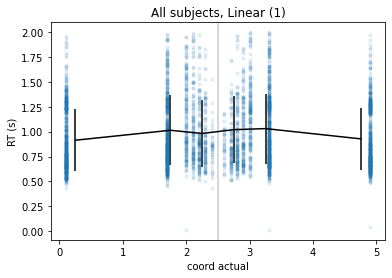

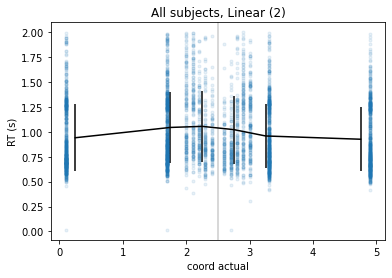

In [21]:
for ti, tt in enumerate([1,2]):

    x = []
    y = []

    for si, ss in enumerate(sublist):

        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = np.array(l['is_main_grid']==1)

        coord_actual = pt_labs[:,ti]

        rt = np.array(l['rt'])
        
        x.append(coord_actual)
        y.append(rt)

    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)

    n_bins = 10;

    x_bin_edges = np.linspace(0, 5.0001, n_bins+1)
    x_binned = np.zeros((n_bins,))
    y_binned = np.zeros((n_bins,2))

    for bi in range(n_bins):
        inds = (x>=x_bin_edges[bi]) & (x<x_bin_edges[bi+1]) & ~np.isnan(y)
        if np.sum(inds)>0:
            assert(not np.any(np.isnan(y[inds])))
            x_binned[bi] = np.mean(x_bin_edges[bi:bi+2])
            y_binned[bi,0] = np.mean(y[inds])
            y_binned[bi,1] = np.std(y[inds])
        else:
            x_binned[bi] = np.nan
    keep_inds = ~np.isnan(x_binned)
    x_binned = x_binned[keep_inds]
    y_binned = y_binned[keep_inds,:]

    plt.figure()

    inds = ~np.isnan(y)
    plt.plot(x[inds], y[inds], '.', alpha=0.1)

    plt.errorbar(x_binned, y_binned[:,0], y_binned[:,1], color='k')
    plt.xlabel('coord actual')
    plt.ylabel('RT (s)')

    plt.title('All subjects, %s'%(task_names[ti]));
    # plt.xlim([-0.2, 5.2])
    # plt.ylim([0.6, 2.4])   
    plt.axvline(2.5, color=[0.8,0.8,0.8])